/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


feature=0, cost=4436186.261772685, divide_value=20.600196926181816
choose_feature=0, cost=4436186.261772685, divide_value=20.600196926181816
feature=0, cost=544607.6014419745, divide_value=14.024569037232322
choose_feature=0, cost=544607.6014419745, divide_value=14.024569037232322
feature=0, cost=116682.98312567509, divide_value=8.548703284888889
choose_feature=0, cost=116682.98312567509, divide_value=8.548703284888889
feature=0, cost=14652.99497803636, divide_value=5.252533205333334
choose_feature=0, cost=14652.99497803636, divide_value=5.252533205333334
feature=0, cost=836.3378399772895, divide_value=3.9557976909292933
choose_feature=0, cost=836.3378399772895, divide_value=3.9557976909292933
feature=0, cost=124.34352894005514, divide_value=0.9534199967878789
choose_feature=0, cost=124.34352894005514, divide_value=0.9534199967878789
feature=0, cost=0.0, divide_value=4.236464973
choose_feature=0, cost=0.0, divide_value=4.236464973
feature=0, cost=5184.418738898319, divide_value=5.33213

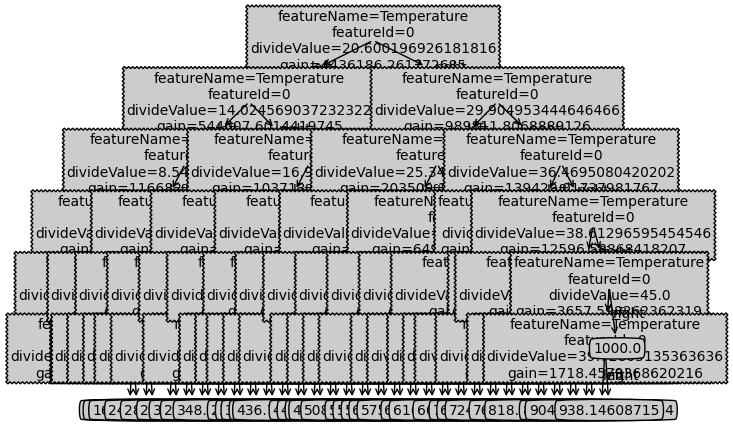

剪枝后 r2=0.9815924645583074


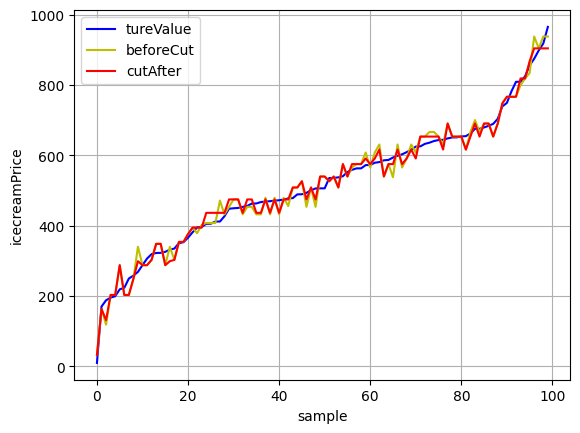

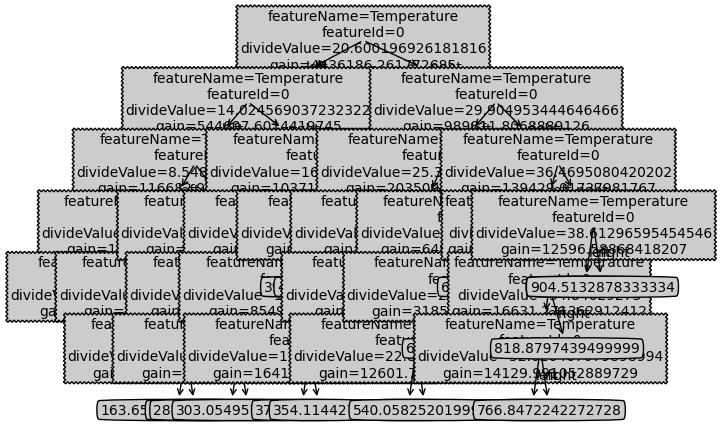

/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


feature=0, cost=21560.31878479331, divide_value=52.0
feature=1, cost=19409.03657540485, divide_value=6.545666454757327
feature=2, cost=21990.10558198934, divide_value=1.355555555555553
feature=3, cost=20635.651558587466, divide_value=37.95787878787879
feature=4, cost=21307.13578146204, divide_value=-121.81464646464646
choose_feature=1, cost=19409.03657540485, divide_value=6.545666454757327
feature=0, cost=14332.066906469367, divide_value=52.0
feature=1, cost=14413.931039175506, divide_value=5.796776428545378
feature=2, cost=14619.547226129282, divide_value=1.118104118104117
feature=3, cost=13749.281905243695, divide_value=37.95787878787879
feature=4, cost=14183.952738400687, divide_value=-121.83787878787878
choose_feature=3, cost=13749.281905243695, divide_value=37.95787878787879
feature=0, cost=12582.449482320888, divide_value=52.0
feature=1, cost=12601.910547905645, divide_value=5.681645670815342
feature=2, cost=12947.871765747659, divide_value=1.1077441077441075
feature=3, cost=1256

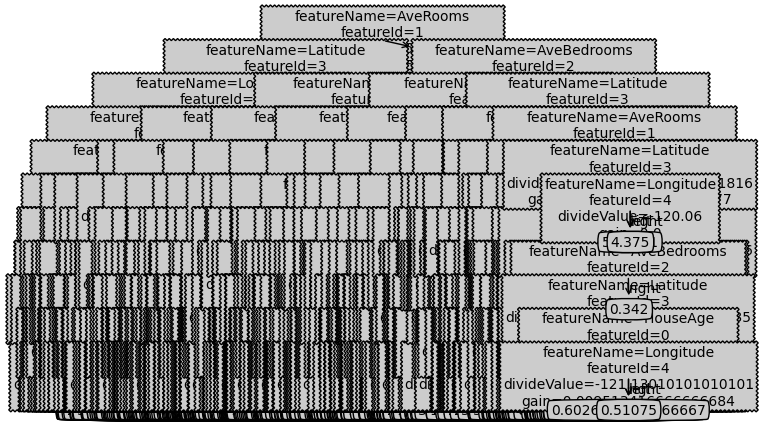

剪枝后模型r2=0.7631565865940897


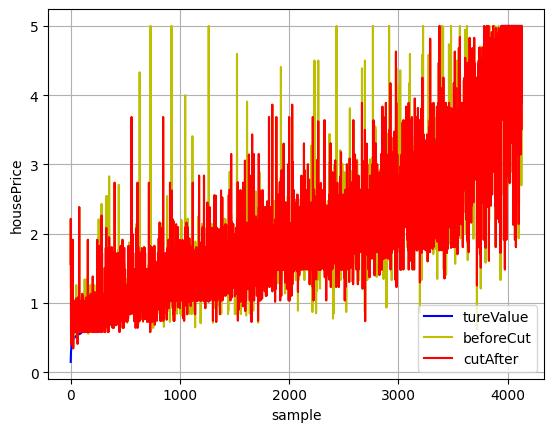

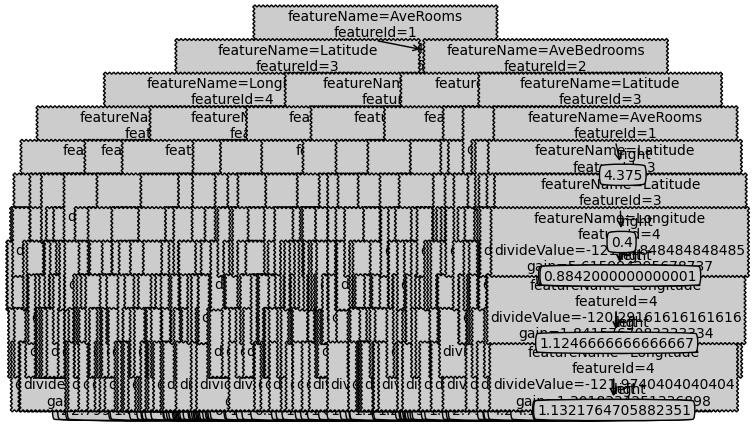

In [3]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
# author: 徐聪
# datetime: 2022-11-04 12:05
# software: PyCharm
import math
import sys

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import plottree
import pickle
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt


class DT:

    def __init__(self, depth):
        self.depth = depth

    def postPruning(self, dtree, subtree, X, y):
        """
        dfs算法对决策树进行后剪枝
        :param subtree:
        :param dtree:
        :param X:
        :param y:
        :return:
        """
        # 叶子节点不用剪枝
        if type(subtree).__name__ != "dict":
            return

        # dfs遍历左右节点
        key = next(iter(subtree))
        self.postPruning(dtree, subtree[key]["left"], X, y)
        self.postPruning(dtree, subtree[key]["right"], X, y)

        # 不剪枝前决策树的代价
        old_cost = self.getTreeCost(dtree, X, y)

        # 对subtree的左子树进行剪枝处理
        sides = ["left", "right"]
        for side in sides:
            if type(subtree[key][side]).__name__ == "dict":
                # 获取左子树的所有叶节点
                leaves = []
                self.getSubTreeLeaf(subtree[key][side], leaves)

                temp_subtree = subtree[key][side]
                best_leaf = leaves[0]
                min_cost = sys.maxsize
                for leaf in leaves:
                    # 预剪枝
                    subtree[key][side] = leaf
                    new_cost = self.getTreeCost(dtree, X, y)
                    if new_cost <= min_cost:
                        min_cost = new_cost
                        best_leaf = leaf

                    # 恢复原状
                    subtree[key][side] = temp_subtree

                # 若剪枝后的准确性提高则进行剪枝处理
                if min_cost <= old_cost:
                    subtree[key][side] = best_leaf

    def getSubTreeLeaf(self, tree, leaves):
        """
        获取叶节点
        :param tree:
        :param leaves:
        :return:
        """
        if type(tree).__name__ != "dict":
            if tree not in leaves:
                leaves.append(tree)
            return

        key = next(iter(tree))
        self.getSubTreeLeaf(tree[key]["left"], leaves)
        self.getSubTreeLeaf(tree[key]["right"], leaves)

    def getTreeCost(self, dtree, X, y):
        """
        获取决策树的cost
        :param dtree: 决策树
        :param X: 样本特征
        :param y: 正确标签
        :return:
        """
        pre_y = np.array(self.predict(dtree, X))
        cost = np.dot(pre_y - y, (pre_y - y).T)
        return cost

    def predict(self, dtree, X):
        """
        批量获取预测结果
        :param dtree: 决策树
        :param X: 待测样本特征
        :return:
        """
        y_pre = []
        for x in X:
            y_pre.append(self.getPredict(dtree, x))

        return y_pre

    def getPredict(self, dtree, X):
        """
        dfs算法获取预测结果
        :param dtree: 决策树
        :param features: 待预测样本特征
        :return:
        """
        if type(dtree).__name__ != "dict":
            return dtree

        # 获取决策树节点
        key = next(iter(dtree))
        sub_tree = dtree[key]

        feature_index, divide_value = key[1], key[2]

        if X[feature_index] >= divide_value:
            return self.getPredict(sub_tree["right"], X)
        else:
            return self.getPredict(sub_tree["left"], X)

    def createDecTree(self, X, y, id2name, depth):
        """
        创建决策树函数
        :param id2name:
        :param X:
        :param y:
        :return:
        """
        labels = list(set(y))
        if depth > self.depth:
            return self.getAvgValue(y)

        # 若当前数据集中只有一种label的样本，则直接返回唯一的label
        if len(labels) == 1:
            return labels[0]

        # 只有一种属性且所有属性值相同
        if len(X[0]) == 1 and len(list(set(X[:, 0]))) == 1:
            return self.getAvgValue(y)

        # 若当前数据集中无特征，则返回最多的样本label
        if len(X[0]) == 0:
            return self.getAvgValue(y)

        # 当前最优的feature
        best_feature, feature_divide_value, cost = self.getBestFeature(X, y)

        # 构建当前数据下的决策树
        key = (id2name[best_feature], best_feature, feature_divide_value, cost)
        deTree = {key: {}}

        # 获取大于value以及小于value的子数据集
        sub_X_left, sub_y_left, sub_X_right, sub_y_right = self.spiltDataSetByFeature(X, y, best_feature,
                                                                                      feature_divide_value)

        deTree[key]["left"] = self.createDecTree(sub_X_left, sub_y_left, id2name, depth+1)
        deTree[key]["right"] = self.createDecTree(sub_X_right, sub_y_right, id2name, depth+1)

        return deTree

    def getAvgValue(self, y):
        """
        获取当前数据集的平均值
        :param y:
        :return:
        """
        return np.average(y)

    def getBestFeature(self, X, y):
        """
        从当前数据集中选择信息增益最大的属性
        :param X:
        :param y:
        :return:
        """
        # 获取标签以及样本的数量
        cnt_feature = len(X[0])
        cnt_sample = len(X)

        # 计算数据集原始的信息熵
        best_feature = 0
        best_feature_divide_value = 0
        min_feature_cost = sys.maxsize

        # 计算每个属性的信息增益
        for i in range(len(X[0])):
            # 获取当前属性的取值
            # feature_values = np.sort(np.array(list(set(X[:, i]))))
            #
            # # 获取切分的所有值
            # divide_values = []
            # for j in range(len(feature_values) - 1):
            #     divide_values.append((feature_values[j] + feature_values[j + 1]) / 2)

            divide_values = np.linspace(np.min(X[:, i]), np.max(X[:, i]), 100)


            min_cost = sys.maxsize
            feature_divide_value = 0

            # 对于每个属性取值计算对应的信息熵
            for value in divide_values:
                # 按照属性的取值获取子数据集
                sub_X_left, sub_y_left, sub_X_right, sub_y_right = self.spiltDataSetByFeature(X, y, i, value)

                cost = np.dot(sub_y_left - np.average(sub_y_left), (sub_y_left - np.average(sub_y_left)).T)
                cost += np.dot(sub_y_right - np.average(sub_y_right), (sub_y_right - np.average(sub_y_right)).T)

                if cost <= min_cost:
                    min_cost = cost
                    feature_divide_value = value

            print(f"feature={i}, cost={min_cost}, divide_value={feature_divide_value}")

            if min_cost <= min_feature_cost:
                min_feature_cost = min_cost
                best_feature = i
                best_feature_divide_value = feature_divide_value

        print(f"choose_feature={best_feature}, cost={min_feature_cost}, divide_value={best_feature_divide_value}")

        return best_feature, best_feature_divide_value, min_feature_cost

    def spiltDataSetByFeature(self, X, y, feature, value):
        """
        根据特征以及对应的特征值获取子数据集
        :param data:
        :param feature:
        :param value:
        :return:
        """
        sub_X_left = []
        sub_y_left = []
        sub_X_right = []
        sub_y_right = []

        for i in range(len(X)):
            if X[i][feature] >= value:
                sub_X_right.append(X[i])
                sub_y_right.append(y[i])
            else:
                sub_X_left.append(X[i])
                sub_y_left.append(y[i])

        return np.array(sub_X_left), np.array(sub_y_left), np.array(sub_X_right), np.array(sub_y_right)

    def calcDataEnt(self, X, y):
        """
        计算数据集的信息熵
        :param X:
        :param y:
        :return:
        """
        # 获取获取样本数量
        num_sample = len(X)
        # 获取数据集中的标签以及对应的数量
        labels = y
        num_labels = {}
        for label in labels:
            if label not in num_labels.keys():
                num_labels[label] = 1
            else:
                num_labels[label] += 1

        # 计算信息熵
        data_Ent = 0.0
        for label in num_labels.keys():
            p_k = num_labels[label] / num_sample
            data_Ent -= p_k * math.log2(p_k)

        return data_Ent


def icecream_classify():
    data_path = r"icecream_data.xls"
    tree_path = r"icecream.txt"
    df = pd.read_excel(data_path)

    X = pd.DataFrame(df).values[:, :-1]
    y = pd.DataFrame(df).values[:, -1]
    feature_name = list(df.columns)[:-1]
    id2name = {}
    name2id = {}
    for i in range(len(feature_name)):
        id2name[i] = feature_name[i]
        name2id[feature_name[i]] = i

    # 训练集和测试集切分
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    df2 = pd.DataFrame(np.hstack([y_test.reshape((len(y_test), 1)), x_test])).sort_values(0).values
    y_test = df2[:, 0]
    x_test = df2[:, 1:]

    dt = DT(len(X[0])*5)
    dtree = dt.createDecTree(x_train, y_train, id2name, 0)

    print(f"剪枝前 r2={r2_score(y_test, dt.predict(dtree, x_test))}")
    plottree.createPlot(dtree)
    plt.figure()
    plt.plot(range(len(y_test)), y_test, 'b-', label="tureValue")
    plt.plot(range(len(y_test)), dt.predict(dtree, x_test), 'y-', label="beforeCut")

    dt.postPruning(dtree, dtree,x_test, y_test)

    print(f"剪枝后 r2={r2_score(y_test, dt.predict(dtree, x_test))}")
    plt.plot(range(len(y_test)), dt.predict(dtree, x_test), 'r-', label="cutAfter")
    plt.xlabel("sample")
    plt.ylabel("icecreamPrice")
    plt.grid()
    plt.legend()
    plt.show()
    plottree.createPlot(dtree)

def housing_classify():
    data_path = r"housing_data.xls"
    tree_path = r"housing_dt.txt"
    df = pd.read_excel(data_path)

    X = pd.DataFrame(df).values[:, :-1]
    y = pd.DataFrame(df).values[:, -1]
    feature_name = list(df.columns)[:-1]
    id2name = {}
    name2id = {}
    for i in range(len(feature_name)):
        id2name[i] = feature_name[i]
        name2id[feature_name[i]] = i

    # 训练集和测试集切分
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    df2 = pd.DataFrame(np.hstack([y_test.reshape((len(y_test), 1)), x_test])).sort_values(0).values
    y_test = df2[:, 0]
    x_test = df2[:, 1:]

    dt = DT(len(X[0])*2)
    dtree = dt.createDecTree(x_train, y_train, id2name, 0)
    # print(dtree)

    print(f"剪枝前模型r2={r2_score(y_test, dt.predict(dtree, x_test))}")
    plottree.createPlot(dtree)
    plt.figure(1)
    plt.plot(range(len(y_test)), y_test, 'b-', label="tureValue")
    plt.plot(range(len(y_test)), dt.predict(dtree, x_test), 'y-', label="beforeCut")
    dt.postPruning(dtree, dtree, x_test, y_test)

    print(f"剪枝后模型r2={r2_score(y_test, dt.predict(dtree, x_test))}")
    plt.plot(range(len(y_test)), dt.predict(dtree, x_test), 'r-', label="cutAfter")
    plt.xlabel("sample")
    plt.ylabel("housePrice")
    plt.grid()
    plt.legend()
    plt.show()
    plottree.createPlot(dtree)


if __name__ == '__main__':
    icecream_classify()
    housing_classify()
